##  이번 작업에 포함된 내용
- 멀티클래스(레이블이 3개이상인자료)에서의 classification_report 의 정밀도, 재현율, f1스코어를 계산법
- 인접정밀도 조정하기: y값과 y예측값의 일치율이 아닌 일정 범위의 차이를 일치율로 보기

- y값의 연속형 변수(소득:income.num)를 10개구간으로 나누기

- 10개구간에 대한 분류를 LGBM, 랜덤포레스트로 실행하기
- 인접정밀도를 조정하여 LGBM, 랜덤포레스트 정밀도 높이기

- 소득구간을 조정하여 예측률 높이기

In [2]:
# 메모리내 변수 제거

all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]    # _로 시작하지 않는 모든 자료 삭제함

- 다중클래스에서의 정밀도, 재현율등 계산법
- 다중 클래스는 OvR(One-vs.-Rest) 문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여

[[1 2 0]
 [0 1 0]
 [0 1 2]]


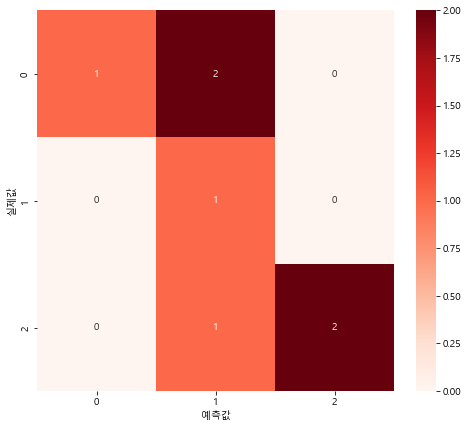

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true = np.array([0, 0, 0, 1,2,2,2])
y_pred = np.array([0, 1, 1, 1,1,2,2])

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
print(cm)

## 히트맵으로 시각화하기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

plt.figure(figsize=[8,7])
sns.heatmap(cm, cmap='Reds', annot=True, fmt='.0f')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

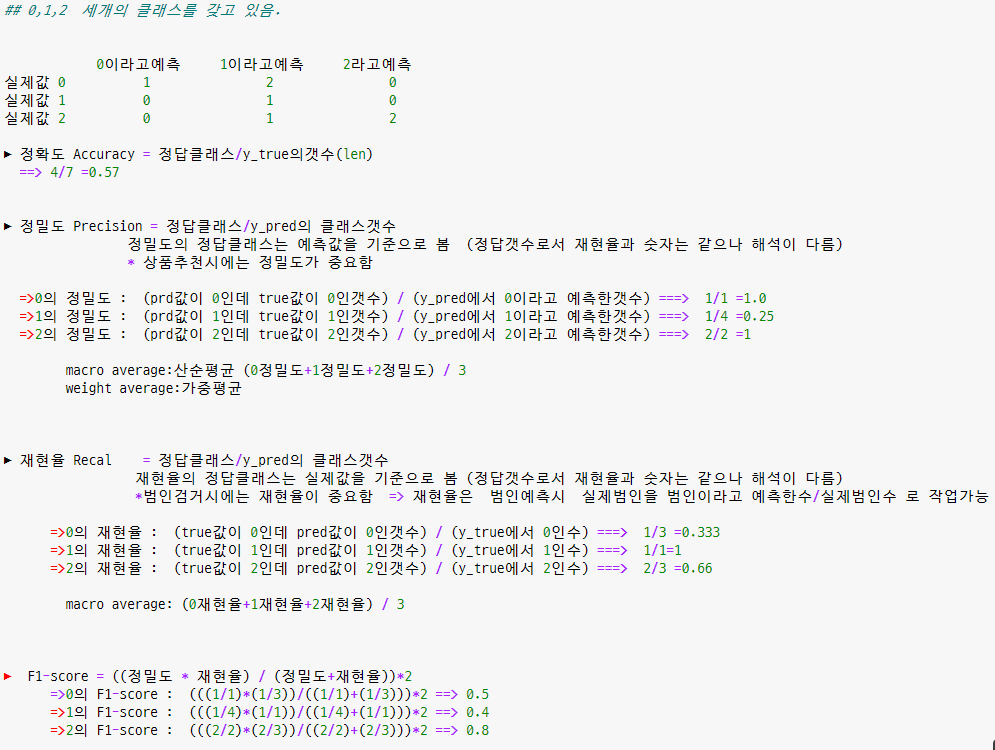

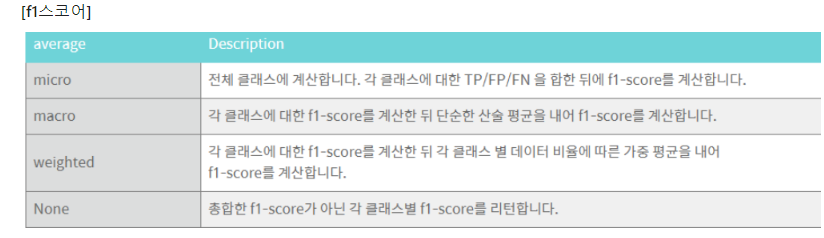

- 클래스 불균형(Imbalance) 문제가 있는 데이터셋에서는 Micro-average가 조금 더 효과적인 평가지표가 됨.
- Macro 값은 0.4로 정밀도의 평균에 더 가깝고, Micro 값은 0.123으로, 많이 관측된 클래스의 정밀도에 가까우며 Micro 는 샘플의 수에 영향을 받아서 클래스별 샘플 수를 고려한 Micro가 불균형 데이터셋에 있어 좋음

In [ ]:
# F1 스코어 


In [ ]:
# 분류 리포트 

### 정밀도 높이기

In [ ]:
# y예측값과 y값이 같은값일때만
precise_accuracy = np.sum(y_pred == y_true) / len(y_pred)

# y예측값과 y값의 차이가 1이하일때는 같은값으로 봄 (abs는 절대값)
adjacent_accuracy = np.sum(np.abs(y_pred - y_true) <= 1) / len(y_pred)

print('------- 정밀도 ----------')
print(precise_accuracy)

print('\n-------- 인접율 --------')
print(adjacent_accuracy)

### [실습] 소득구간을 조정하여 예측률 높이기
    income_ext.csv

    - age : 나이
    - workclass: 직업구분
    - education: 교육수준
    - education.num: 교육수준(numerically coded)
    - marital.status: 혼인상태
    - occupation : 직업
    - relationship: 가족관계
    - sex: 성별
    - capital.gain: 자본이득
    - capital.loss: 자본손실
    - hours.per.week: 주당 근로시간
    - spending.groc: 식료품 소비 금액(continuous) ++
    - spending.med: 병의원 소비 금액(continuous) ++
    - spending.trav: 여행 레저 소비 금액(continuous) ++
    - income : 소득 이진구분( <=50K: 0, >50K: 1 ) +
    - income.num : 소득금액(continuous) ++

### [1] 데이터 로드 및 확인

In [49]:
import pandas as pd

data =  pd.read_csv('income_ext.csv')
print(data.shape)
print(data.columns)

(32561, 19)
Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'spend.groc', 'spend.med', 'spend.trav', 'asset',
       'balance', 'native.country', 'income', 'income.num'],
      dtype='object')


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education.num   32561 non-null  int64 
 4   marital.status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   sex             32561 non-null  object
 8   capital.gain    32561 non-null  int64 
 9   capital.loss    32561 non-null  int64 
 10  hours.per.week  32561 non-null  int64 
 11  spend.groc      32561 non-null  int64 
 12  spend.med       32561 non-null  int64 
 13  spend.trav      32561 non-null  int64 
 14  asset           32561 non-null  int64 
 15  balance         32561 non-null  int64 
 16  native.country  32561 non-null  object
 17  income          32561 non-null  int64 
 18  income

In [14]:
data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country,income,income.num
0,90,?,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States,0,43713
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States,0,33113
2,66,?,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States,0,31652
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States,0,55087
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States,0,85583


In [15]:
tmp=data['income'].value_counts()


# 7841/(24720+7841)

bi=[]
bi.append(tmp[0]/(tmp[0]+tmp[1]))
bi.append(tmp[1]/(tmp[0]+tmp[1]))

tmp,bi

(0    24720
 1     7841
 Name: income, dtype: int64,
 [0.7591904425539756, 0.2408095574460244])

27905

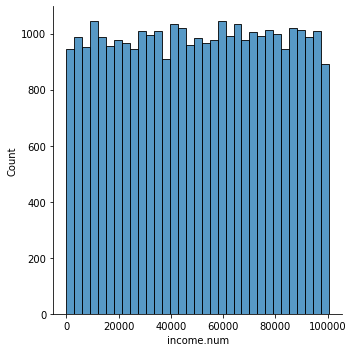

In [21]:
## incom의 hist 그리기
import seaborn as sns
sns.displot(data['income.num'])

len(data['income.num'].value_counts())

In [50]:
def aa(xx):
    result=[]
    for x in xx:
        if x<=10000:
            result.append(0)
        elif x>10000 and x<=20000:
            result.append(1)
        elif x>20000 and x<=30000:
            result.append(2)
        elif x>30000 and x<=40000:
            result.append(3)
        elif x>40000 and x<=50000:
            result.append(4)
        elif x>50000 and x<=60000:
            result.append(5)
        elif x>60000 and x<=70000:
            result.append(6)
        elif x>70000 and x<=80000:
            result.append(7)
        elif x>80000 and x<=90000:
            result.append(8)
        elif x>90000 and x<=100000:
            result.append(9)
        else:
            result.append(10)
    return result
            

In [70]:
# 숫자로 들어온 incom.num 자료를 구간별 자료(범주형 자료로)로 제작
def value_change(x):
    if x<=10000: return 0
    if x>10000 and x<=20000: return 1
    if x>20000 and x<=30000: return 2
    if x>30000 and x<=40000: return 3
    if x>40000 and x<=50000: return 4
    if x>50000 and x<=60000: return 5
    if x>60000 and x<=70000: return 6
    if x>70000 and x<=80000: return 7
    if x>80000 and x<=90000: return 8
    if x>90000 and x<=100000: return 9
    return 10

y=data['income.num']
y=y.apply(lambda x: value_change(x))  ## Apply Lambda function
y  

0        4
1        3
2        3
3        5
4        8
        ..
32556    0
32557    8
32558    4
32559    7
32560    3
Name: income.num, Length: 32561, dtype: int64

### [2] x,y 데이터 제작

In [72]:
data['income_gu']=y
data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country,income,income.num,income_gu
0,90,?,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States,0,43713,4
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States,0,33113,3
2,66,?,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States,0,31652,3
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States,0,55087,5
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States,0,85583,8


In [76]:
X=data.drop(['income','income.num','income_gu'],axis=1)
y=data['income_gu']


In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education.num   32561 non-null  int64 
 4   marital.status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   sex             32561 non-null  object
 8   capital.gain    32561 non-null  int64 
 9   capital.loss    32561 non-null  int64 
 10  hours.per.week  32561 non-null  int64 
 11  spend.groc      32561 non-null  int64 
 12  spend.med       32561 non-null  int64 
 13  spend.trav      32561 non-null  int64 
 14  asset           32561 non-null  int64 
 15  balance         32561 non-null  int64 
 16  native.country  32561 non-null  object
dtypes: int64(10), object(7)
memory usage: 4.2+ MB


### [3] feature Engineering

In [80]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [82]:
from sklearn import preprocessing

categorical = ['workclass','education', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']

## 문자자료를 숫자자료로 변경함.
for feature in categorical:
        le =  preprocessing.LabelEncoder()
        x_train[feature] =  le.fit_transform(x_train[feature])
        x_test[feature] =  le.transform(x_test[feature])

In [83]:
x_train[categorical].head()

,workclass,education,marital.status,occupation,relationship,sex,native.country
32098,7,9,2,4,5,0,39
25206,2,11,2,7,0,1,39
23491,4,15,4,4,1,0,39
12367,2,11,4,5,3,1,39
7054,1,12,2,4,0,1,39


In [85]:
categorical = ['workclass','education', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']

for i in categorical:
    print(len(data[i].value_counts()))

9
16
7
15
6
2
42


### [4] Light GBM을 이용한 다중분류 구현
 - boosting_type='gbdt'
     - 'gbdt’, traditional Gradient Boosting Decision Tree.
     - 'dart’, Dropouts meet Multiple Additive Regression Trees.
     -‘goss’, Gradient-based One-Side Sampling.
     -‘rf’, Random Forest

- multi_class='multiclass'

In [94]:
#!pip install lightgbm

In [102]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier(boosting_type='gbdt')
lgbm.fit(x_train, y_train)

## 정확도 구하기
y_pred_lgbm =  lgbm.predict(x_test)

lgbm_score =  accuracy_score(y_test, y_pred_lgbm)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))


LGBM Model accuracy score : 0.8177


In [109]:
## Confusion Matrix 확인하기
from sklearn.metrics import confusion_matrix

cm_lgbm=confusion_matrix(y_test,y_pred_lgbm)

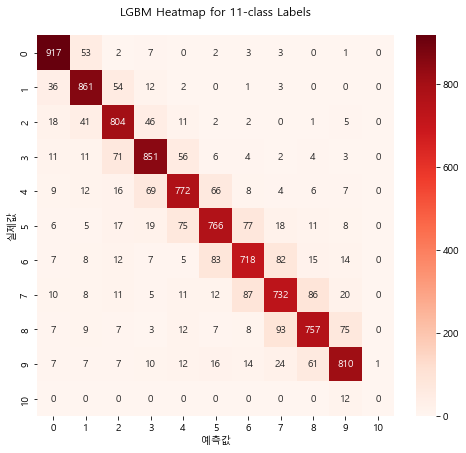

In [112]:
## 히트맵으로 시각화하기
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

plt.figure(figsize=[8,7])
sns.heatmap(cm_lgbm, cmap='Reds', annot=True, fmt='.0f')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('LGBM Heatmap for 11-class Labels\n')
plt.show()

In [115]:
# 리포트 작성
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred_lgbm))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       988
           1       0.85      0.89      0.87       969
           2       0.80      0.86      0.83       930
           3       0.83      0.84      0.83      1019
           4       0.81      0.80      0.80       969
           5       0.80      0.76      0.78      1002
           6       0.78      0.75      0.77       951
           7       0.76      0.75      0.75       982
           8       0.80      0.77      0.79       978
           9       0.85      0.84      0.84       969
          10       0.00      0.00      0.00        12

    accuracy                           0.82      9769
   macro avg       0.74      0.74      0.74      9769
weighted avg       0.82      0.82      0.82      9769



### [5] 모델평가와 개선
- 소득구간을 적절한 클래스 수로 변환하여 모델 개선하기

In [118]:
def value_change(x):
    if x<=20000: return 0
    if x>20000 and x<=50000: return 1
    if x>50000 and x<=70000: return 2
    if x>70000 and x<=90000: return 3
    return 4

y=data['income.num'].apply(lambda x:value_change(x))
y.value_counts()

1    9686
2    6564
3    6533
0    6426
4    3352
Name: income.num, dtype: int64

In [119]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [120]:
from sklearn import preprocessing

categorical = ['workclass','education', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        x_train[feature] = le.fit_transform(x_train[feature])
        x_test[feature] = le.transform(x_test[feature])

In [121]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier(boosting_type='gbdt')
lgbm.fit(x_train, y_train)

## 정확도 구하기
y_pred_lgbm =  lgbm.predict(x_test)

lgbm_score =  accuracy_score(y_test, y_pred_lgbm)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))


LGBM Model accuracy score : 0.9050
